In [214]:
import os
import sys
import pinecone
import numpy as np

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
PINECONE_ENV = os.getenv("PINECONE_ENV")

pinecone.init(
        api_key=PINECONE_API_KEY,
        environment=PINECONE_ENV
)
index = pinecone.Index("test")
vector_count = 1

In [143]:
import openai

ailment = "gingivitis"
result = openai.ChatCompletion.create(model = "gpt-3.5-turbo", temperature = 0.6, messages = [{"role": "user", "content" : "What notes would a doctor have when observing a patient with "+ ailment + "? Include test results. Do not include patient's name, age, gender or any patient specific details including date of observation. Do not tell me that the notes are not comprehensive, I already know this. Do not tell me about anything that requires further investigation."}])

result_text = result["choices"][0]['message']['content']
result_embedding = openai.Embedding.create(
    input=result_text,
    model="text-embedding-ada-002"
)

result_embedding_vec = result_embedding['data'][0]['embedding']

print(result_text)

Patient presents with symptoms consistent with gingivitis, including inflamed and swollen gums, bleeding during brushing and flossing, and bad breath. Upon examination, the following observations were made:

1. Oral Examination:
   - Gingival tissues appear red, swollen, and edematous.
   - Gingival bleeding upon gentle probing.
   - Accumulation of dental plaque and calculus along the gumline.
   - Generalized gingival recession is noted.
   - No signs of periodontal abscess or severe tooth mobility observed.
   - Teeth exhibit no significant mobility or sensitivity upon percussion.

2. Dental X-rays:
   - Bitewing radiographs reveal no evidence of interproximal bone loss.
   - No evidence of severe alveolar bone loss or periodontal pockets observed.
   - No evidence of periapical pathology or significant root resorption identified.

3. Periodontal Examination:
   - Gingival Index: Moderate to severe inflammation observed (score: 2-3 out of 3).
   - Bleeding on Probing Index: Widespre

In [144]:
index.upsert([("vec" + str(vector_count), result_embedding_vec, {"ailment" : ailment})], namespace = "sideproject")
vector_count += 1
# index.delete(delete_all = True, namespace = "sideproject")
# index.describe_index_stats()

In [179]:
queries = {"glaucoma": [],
           "jaundice": [],
           "cyanosis": [],
           "psoriasis": [],
           "conjunctivitis": [],
           "scoliosis": [],
           "skin cancer": [],
           "gingivitis": []
           }

ailments = ["glaucoma", "jaundice", "cyanosis", "psoriasis", "conjunctivitis", "scoliosis", "skin cancer", "gingivitis"]
for a in ailments:
    notes = []
    for i in range(20):
        note = openai.ChatCompletion.create(model = "gpt-3.5-turbo", temperature = 0.7, 
        messages = [{"role": "user", "content" : "What notes would a doctor have when observing a patient with "+ a + "? Make notes short and consise. Labratory test results are optional. Do not include patient's name, age, gender or any patient specific details including date of observation. Do not tell me that the notes are not comprehensive, I already know this. Do not tell me about anything that requires further investigation. Do not tell me what ailment the patient is presented with."}])
        notes.append(note["choices"][0]['message']['content'])
    queries[a] = notes

print(queries)


{'glaucoma': ['- Elevated intraocular pressure (IOP)\n- Cupping of optic disc\n- Visual field loss\n- Corneal thickness within normal range\n- No signs of acute angle-closure glaucoma\n- No signs of secondary glaucoma\n- No abnormalities found in slit-lamp examination\n- No signs of optic nerve head hemorrhage or edema\n- No significant cataract or lens abnormalities', '- Elevated intraocular pressure\n- Optic nerve damage/atrophy\n- Loss of peripheral vision (visual field defects)\n- Cupping of the optic disc\n- Corneal thickness measurement\n- Retinal nerve fiber layer thickness measurement', '- Elevated intraocular pressure\n- Optic nerve damage\n- Visual field loss\n- Cupping of the optic disc\n- Increased cup-to-disc ratio\n- Thin corneal thickness (if applicable)\n- Family history of glaucoma (if applicable)\n- Pupil irregularity (if applicable)\n- Decreased visual acuity\n- Visual disturbances', '- Increased intraocular pressure (IOP)\n- Optic nerve damage\n- Visual field loss\n

In [169]:
#add all results of queries and append them into lists in real_queries
real_queries = {"glaucoma": [],
                "jaundice": [],
                "cyanosis": [],
                "psoriasis": [],
                "conjunctivitis": [],
                "scoliosis": [],
                "skin cancer": [],
                "gingivitis": []}

In [234]:
# for a in queries:
#     for q in queries[a]:
#         real_queries[a].append(q)

# print(len(real_queries["jaundice"]))
sys.stdout = open("output2.txt", "w")


In [235]:
#this will be the same as real_queries, but it will combine every query within a particular ailment, and split it by new lines and then make a flattened list of all the lines
real_queries2 = {}

for a in real_queries:
    ailment_list = []
    for q in real_queries[a]:
        ailment_list.append(q.splitlines())
    #flatten ailment_list
    ailment_list = [item for sublist in ailment_list for item in sublist]
    real_queries2[a] = ailment_list

print(real_queries2)


In [4]:
from sklearn.metrics import confusion_matrix
confusion_matricies = [[0 for i in range(8)] for j in range(8)]

threshold = 0.8

y_true = []
y_pred = []

for query in real_queries:
    for i in range(5):
        note = real_queries[query][i]
        outputs = index.query(
            vector = openai.Embedding.create(input = note, model = "text-embedding-ada-002")['data'][0]['embedding'], 
            top_k = 1,
            namespace = 'sideproject',
            include_values = True,
            include_metadata = True
        )
        # # if the score is greater than the threshold, then update the confusion matrix otherwise do nothing
        # if  >= threshold:
        #     #confusion_matrices[actual][predicted]
        #     confusion_matricies[indices[query]][indices[outputs['matches'][0]['metadata']['ailment']]] += 1

        y_true.append(query)
        y_pred.append(outputs['matches'][0]['metadata']['ailment'])

confusion_matrix = confusion_matrix(y_true, y_pred, labels = ailments)

# for l in confusion_matricies:
#     print(l)

NameError: name 'real_queries' is not defined

In [1]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")

tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")
inputs = tokenizer("A intro paragraph on a article on space travel:", return_tensors="pt")


outputs = model.generate(**inputs, max_length = 100)
print(tokenizer.batch_decode(outputs, skip_special_tokens=True))


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['Space travel is a form of space travel that involves a person or group of people traveling in space.']


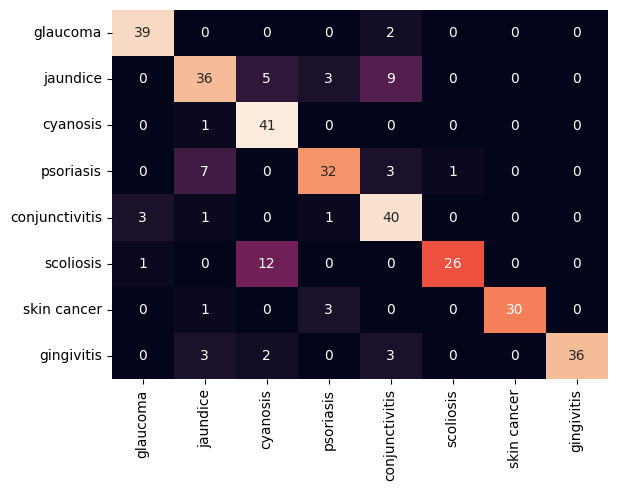

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

ailments = ["glaucoma", "jaundice", "cyanosis", "psoriasis", "conjunctivitis", "scoliosis", "skin cancer", "gingivitis"]

#8x8 matrix
matrix = np.array([[90, 0, 0, 0, 3, 0, 0, 0],
                  [0, 71, 5, 3, 9, 0, 0, 0],
                  [0, 2, 78, 0, 0, 2, 0, 0],
                  [1, 10, 1, 69, 3, 1, 0, 2],
                  [4, 3, 0 ,1, 83, 1, 0, 0],
                  [1, 1, 14 ,0, 0, 67, 0, 0],
                  [0, 3, 0 ,11, 0, 1, 68, 1],
                  [0, 3, 2, 0, 3, 1, 0, 75]])

#8x8 matrix of zeros
matrix2 = np.array([[51, 0, 0, 0, 1, 0, 0, 0],
                    [0, 35, 0, 0, 0, 0, 0, 0],
                    [0 , 1, 37, 0, 0, 2, 0, 0],
                    [1 ,3 ,1 , 37 ,0 ,0 ,0 ,2],
                    [1 ,2 ,0 ,0 , 43 ,1 ,0 ,0],
                    [0 ,1 ,2 ,0 ,0 , 41 ,0 ,0],
                    [0 ,2 ,0 ,8 ,0 ,1 , 38 ,1],
                    [0 ,0 ,0 ,0 ,0 ,1 ,0 , 39]])



sns.heatmap(matrix - matrix2, annot = True, xticklabels = ailments, yticklabels = ailments, cbar = False, fmt='g')

plt.show()